In [1]:
!mkdir -p ~/.kaggle
!cp kaggle(1).json ~/.kaggle

import zipfile
zip = zipfile.ZipFile('/content/tomato_leaf_images.zip')
zip.extractall()
zip.close()

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `cp kaggle(1).json ~/.kaggle'


In [2]:
# Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os, glob
import cv2
from pathlib import Path
from skimage.io import imread, imsave
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras import layers as L
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import RMSprop
from keras.applications.vgg16 import VGG16

In [3]:
training_data = '/content/tomato_leaf_images/train'
validation_data = '/content/tomato_leaf_images/val'

In [4]:
y = os.listdir(training_data)
y.remove('.DS_Store')


In [5]:
categories = y
dataframes = {}

for cat in categories:
  dataframes[f'df_{cat}'] = pd.DataFrame({'image_name' : os.listdir(os.path.join(training_data,cat)),
                                          'label' : cat})
len(dataframes)

4

In [6]:
df_SerpentineLeafMiner = list(dataframes.values())[0]

In [7]:
df_SerpentineLeafMiner

,image_name,label
0,IMG_8446_256.jpg,SerpentineLeafMiner
1,IMG_20190223_153027_256.jpg,SerpentineLeafMiner
2,IMG_7714_256.jpg,SerpentineLeafMiner
3,IMG_20190203_153735_256.jpg,SerpentineLeafMiner
4,IMG_20190223_155207_256.jpg,SerpentineLeafMiner
...,...,...
1195,2188_256.jpg,SerpentineLeafMiner
1196,IMG_7871_256.jpg,SerpentineLeafMiner
1197,IMG_7969_256.jpg,SerpentineLeafMiner
1198,IMG_20190223_121223_256.jpg,SerpentineLeafMiner


In [8]:
df_AmericanLeafMiner = list(dataframes.values())[1]
df_Healthy = list(dataframes.values())[2]
df_MagnesiumDeficiency = list(dataframes.values())[3]

df = pd.concat([df_SerpentineLeafMiner, df_AmericanLeafMiner, df_Healthy, df_MagnesiumDeficiency])
df.head()

,image_name,label
0,IMG_8446_256.jpg,SerpentineLeafMiner
1,IMG_20190223_153027_256.jpg,SerpentineLeafMiner
2,IMG_7714_256.jpg,SerpentineLeafMiner
3,IMG_20190203_153735_256.jpg,SerpentineLeafMiner
4,IMG_20190223_155207_256.jpg,SerpentineLeafMiner


In [9]:
df.shape

(4356, 2)

In [10]:
df = df.sample(df.shape[0])

In [11]:
df['image_path'] = df[['image_name', 'label']].apply(lambda x : x[1] + '/' + x[0], axis = 1)

<ipython-input-11-f75110a5866c>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['image_path'] = df[['image_name', 'label']].apply(lambda x : x[1] + '/' + x[0], axis = 1)


In [12]:
df.head()

,image_name,label,image_path
882,IMG_20190630_112851744_256.jpg,Healthy,Healthy/IMG_20190630_112851744_256.jpg
615,IMG_20190407_112221131_256.jpg,MagnesiumDeficiency,MagnesiumDeficiency/IMG_20190407_112221131_256...
197,IMG_20190413_112059_256.jpg,AmericanLeafMiner,AmericanLeafMiner/IMG_20190413_112059_256.jpg
272,resize_IMG_20190623_154154610_BURST000_COVER.jpg,Healthy,Healthy/resize_IMG_20190623_154154610_BURST000...
614,IMG_20190203_122448_256.jpg,MagnesiumDeficiency,MagnesiumDeficiency/IMG_20190203_122448_256.jpg


In [13]:
from tensorflow.keras.preprocessing.image import load_img
x = []
for img in df['image_path']:
  img_path = os.path.join(training_data, img)
  image = load_img(img_path, target_size = (224,224))
  x.append(image)

In [14]:
x = np.array(x)
x.shape

(4356, 224, 224, 3)

In [15]:
y = df['label']


In [16]:
x = x/x.max()

In [17]:
categories = os.listdir(validation_data)
categories.remove('.DS_Store')
dataframes = {}

for cat in categories:
  dataframes[f'df_{cat}'] = pd.DataFrame({'image_name' : os.listdir(os.path.join(validation_data,cat)),
                                          'label' : cat})
len(dataframes)

4

In [18]:
validation_data

'/content/tomato_leaf_images/val'

In [19]:
df_SerpentineLeafMiner = list(dataframes.values())[0]

In [20]:
df_AmericanLeafMiner = list(dataframes.values())[1]
df_Healthy = list(dataframes.values())[2]
df_MagnesiumDeficiency = list(dataframes.values())[3]

df_val = pd.concat([df_SerpentineLeafMiner, df_AmericanLeafMiner, df_Healthy, df_MagnesiumDeficiency])
df_val.head()

,image_name,label
0,IMG_7875_256.jpg,SerpentineLeafMiner
1,2198_256.jpg,SerpentineLeafMiner
2,2355_256.jpg,SerpentineLeafMiner
3,IMG_20190223_151843_256.jpg,SerpentineLeafMiner
4,IMG_8067_256.jpg,SerpentineLeafMiner


In [21]:
df_val.shape

(486, 2)

In [22]:
df_val = df_val.sample(df_val.shape[0])

In [23]:
df_val['image_path'] = df_val[['image_name', 'label']].apply(lambda x : x[1] + '/' + x[0], axis = 1)

<ipython-input-23-a69ac025799c>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_val['image_path'] = df_val[['image_name', 'label']].apply(lambda x : x[1] + '/' + x[0], axis = 1)


In [24]:
from tensorflow.keras.preprocessing.image import load_img
x1 = []
for img in df_val['image_path']:
  img_path = os.path.join(validation_data, img)
  image = load_img(img_path, target_size = (224,224))
  x1.append(image)

In [25]:
x1 = np.array(x1)
x1.shape

(486, 224, 224, 3)

In [26]:
from sklearn.preprocessing import LabelEncoder
import keras
from sklearn.model_selection import train_test_split

# Assuming 'x' is your image data (as an array or image paths) and 'y' is your categorical labels (strings)

# Label Encoding the string labels to numeric
le = LabelEncoder()
y_train = le.fit_transform(df['label'])  # Replace with the correct label column
y_test = le.transform(df_val['label'])  # Replace with the correct label column
# Split the data into train and test sets
x_train, x_test = x, x1

# One-hot encode the labels
y_train = keras.utils.to_categorical(y_train, num_classes=4)  # Assuming 8 categories
y_test = keras.utils.to_categorical(y_test, num_classes=4)

# Now, x_train, x_test, y_train, y_test are ready for training


In [ ]:
from keras.applications.vgg16 import VGG16
from keras import Sequential
from keras.layers import *

base_model = VGG16(include_top = True, weights = 'imagenet', input_shape = (224,224,3))
base_model.trainable = False

model = Sequential()
model.add(base_model)  # Use the VGG16 model with the top layers
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))  # Add a custom dense layer
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = (model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test)))

In [2]:
# Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os, glob
import cv2
from pathlib import Path
from skimage.io import imread, imsave
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras import layers as L
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import RMSprop
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [4]:
x_train.shape

(50000, 32, 32, 3)

In [4]:
x_test.shape

(10000, 32, 32, 3)

In [5]:
categories = len(set(y_train))
categories

TypeError: unhashable type: 'numpy.ndarray'

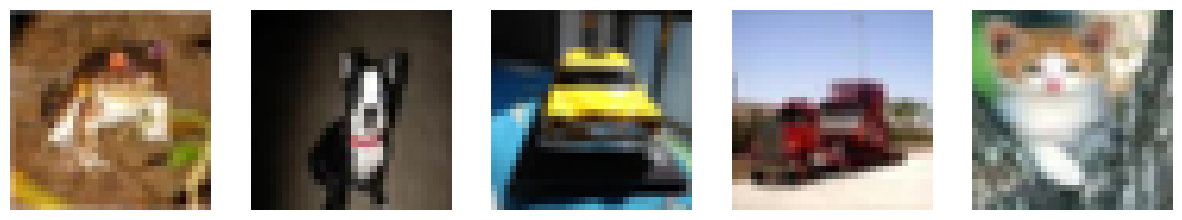

In [5]:
fig,ax = plt.subplots(1, 5, figsize = (15,15))
for i in range(5):
  ax[i].imshow(x_train[i*198])
  ax[i].axis('off')

In [8]:
y_train[0]

array([6], dtype=uint8)

In [19]:
categories = ['airplane',
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck']

In [13]:
y_train.shape

(50000, 1)

In [7]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [8]:
y_train, y_test = y_train.flatten(), y_test.flatten()

In [9]:
from keras.layers import *

i = Input(shape = (32,32,3))
x = Conv2D(32, kernel_size = (3,3), activation = 'relu')(i)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (2,2))(x)
x = Dropout(0.20)(x)
x = Conv2D(64, kernel_size = (3,3), activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (2,2))(x)
x = Dropout(0.20)(x)
x = Conv2D(128, kernel_size = (3,3), activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (2,2))(x)
x = Dropout(0.20)(x)


x = GlobalAveragePooling2D()(x)

x = Dense(256, activation = 'relu')(x)
x = Dropout(0.20)(x)
x = Dense(10, activation = 'softmax')(x)

model = Model(i, x)

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

history = model.fit(x_train, y_train, epochs = 50, batch_size = 64, validation_data = (x_test, y_test))

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 141s 167ms/step - accuracy: 0.3863 - loss: 1.6918 - val_accuracy: 0.4898 - val_loss: 1.4422
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 134s 157ms/step - accuracy: 0.5776 - loss: 1.1855 - val_accuracy: 0.6219 - val_loss: 1.0649
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 149s 166ms/step - accuracy: 0.6265 - loss: 1.0513 - val_accuracy: 0.6383 - val_loss: 1.0029
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 124s 159ms/step - accuracy: 0.6618 - loss: 0.9519 - val_accuracy: 0.6853 - val_loss: 0.8840
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 145s 162ms/step - accuracy: 0.6871 - loss: 0.8883 - val_accuracy: 0.6896 - val_loss: 0.8743
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 130s 146ms/step - accuracy: 0.7002 - loss: 0.8525 - val_accuracy: 0.7101 - val_loss: 0.8265
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 117s 150ms/step - accuracy: 0.7128 - loss: 0.8114 - val_accuracy: 0.6042 - val_loss: 1.1523
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 114s 146ms/step - accuracy: 0.7281 -

In [11]:
frog_img = load_img('/content/frog_image.jpeg', target_size = (32,32))
frog_img_arr = np.array(frog_img)
frog_img_arr = frog_img_arr / 255.0

In [21]:
pred_img = model.predict(frog_img_arr.reshape(1, 32, 32, 3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [18]:
categories[1]

'bird'

In [22]:
categories[np.argmax(pred_img)]

'frog'

In [23]:
air_image = load_img('/content/airplane-image.jpeg', target_size = (32,32))
air_image_arr = np.array(air_image)
air_imagr_arr = air_image_arr/255.0

In [24]:
air_pred = model.predict(air_image_arr.reshape(1, 32, 32, 3))
categories[np.argmax(air_pred)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


'airplane'

In [32]:
history = model.fit(x_train, y_train, epochs = 50, batch_size = 128, validation_data = (x_test, y_test))

Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.8439 - loss: 0.4393 - val_accuracy: 0.7966 - val_loss: 0.6213
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8454 - loss: 0.4324 - val_accuracy: 0.7970 - val_loss: 0.6231
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8489 - loss: 0.4282 - val_accuracy: 0.8079 - val_loss: 0.5747
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8470 - loss: 0.4334 - val_accuracy: 0.8078 - val_loss: 0.5805
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8460 - loss: 0.4273 - val_accuracy: 0.8006 - val_loss: 0.6148
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8469 - loss: 0.4282 - val_accuracy: 0.8068 - val_loss: 0.5832
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8487 - loss: 0.4222 - val_accuracy: 0.8038 - val_loss: 0.5744
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8510 - loss: 0.4232 - val_accuracy: 